In [1]:
import os, sys
sys.path.append('/workspaces/python-trend-labeller')

In [2]:
import pandas as pd

from src.viz import plot_trend_labels
from src.returns_estimation import ReturnsEstimatorWithFees
from src.optimization import Optimizer
from src.returns_estimation.fees_config import FeesConfig
from src.trend_labelling import BinaryCTL

In [17]:
#Utility to plot a parameter grid
from itertools import product

from matplotlib import pyplot as plt
from trend_labelling.label_scaling import Labels


def _plot_labeller_base(labeller_class, time_series: list[float], grid_shape: tuple[int,int], figsize: tuple[int,int], param_sets: list[dict]) -> None:
    """
    Base plotting function for labeller parameter visualization.
    
    Args:
        labeller_class: The labeller class to instantiate
        time_series: List of price values to label
        grid_shape: Tuple of (rows, cols) for the plot grid
        figsize: Tuple of figure dimensions
        param_sets: List of parameter dictionaries to use for labelling
    """
    # Create figure and axes grid
    fig, axes = plt.subplots(*grid_shape, figsize=figsize)
    plt.subplots_adjust(hspace=0.2, wspace=0.1)
    axes_flat = axes.T.flatten()
    
    # Create plots for each parameter set
    for idx, params in enumerate(param_sets):
        if idx >= len(axes_flat):
            break
            
        # Instantiate labeller with current parameters and get labels
        labeller = labeller_class(**params)
        labels = labeller.get_labels(time_series)
        
        # Plot on current subplot
        ax = axes_flat[idx]
        ax.plot(time_series, color='black', linewidth=1)
        
        # Color background based on labels
        for t in range(len(time_series)):
            if labels[t] == Labels.UP:  # Uptrend
                ax.axvspan(t, t+1, color="darkgreen", alpha=0.3)
            elif labels[t] == Labels.DOWN:  # Downtrend
                ax.axvspan(t, t+1, color="brown", alpha=0.3)
            elif labels[t] == Labels.NEUTRAL:  # Neutral trend (for ternary labellers)
                ax.axvspan(t, t+1, color="white", alpha=0.2)
        
        # Format title with parameter values        
        title = ", ".join(f"{k}={v}" for k,v in params.items())
        ax.set_title(title, fontsize=10)
        ax.grid(True)
        ax.tick_params(axis='both', which='major', labelsize=8)

    plt.show()

def plot_parameter_grid(labeller_class, time_series: list[float], param_grid: dict, grid_shape: tuple[int,int]=(3,3), figsize: tuple[int,int]=(15,15)) -> None:
    """
    Plot a grid of trend labels for different parameter combinations.
    
    Args:
        labeller_class: The labeller class to instantiate
        time_series: List of price values to label
        param_grid: Dict mapping parameter names to lists of values to try
        grid_shape: Tuple of (rows, cols) for the plot grid
        figsize: Tuple of figure dimensions
    """
    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    param_sets = [dict(zip(param_names, combo)) for combo in product(*param_values)]
    
    _plot_labeller_base(labeller_class, time_series, grid_shape, figsize, param_sets)

def plot_single_labeller_grid(labeller_class, time_series: list[float], param_list: list[dict], grid_shape: tuple[int,int]=(3,3), figsize: tuple[int,int]=(15,15)) -> None:
    """
    Plot a grid showing labelling results for different parameter sets of the same labeller.
    
    Args:
        labeller_class: The labeller class to instantiate
        time_series: List of price values to label
        param_list: List of parameter dictionaries, each containing a set of parameters for the labeller
        grid_shape: Tuple of (rows, cols) for the plot grid
        figsize: Tuple of figure dimensions
    """
    _plot_labeller_base(labeller_class, time_series, grid_shape, figsize, param_list)



# Table of Contents
1. [Using the Binary CTL labeller](#1-using-the-binary-ctl-labeller)
2. [Optimize different labellers](#optimize-different-labellers)



Let's import the data.

In [3]:
time_series = pd.read_csv("../tests/data/closing_prices.csv", header=None).iloc[:,0].tolist()

# 1. Using the Binary CTL labeller

We can now instantiate a binary parametrized labeller.

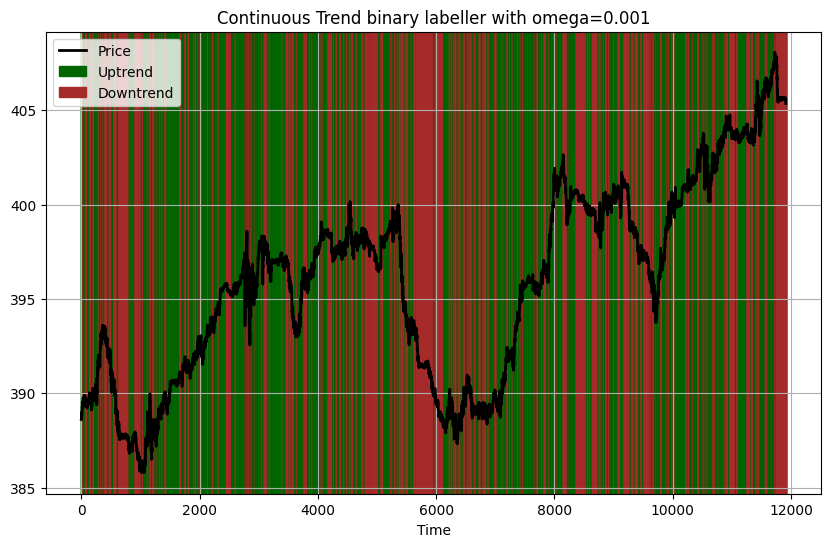

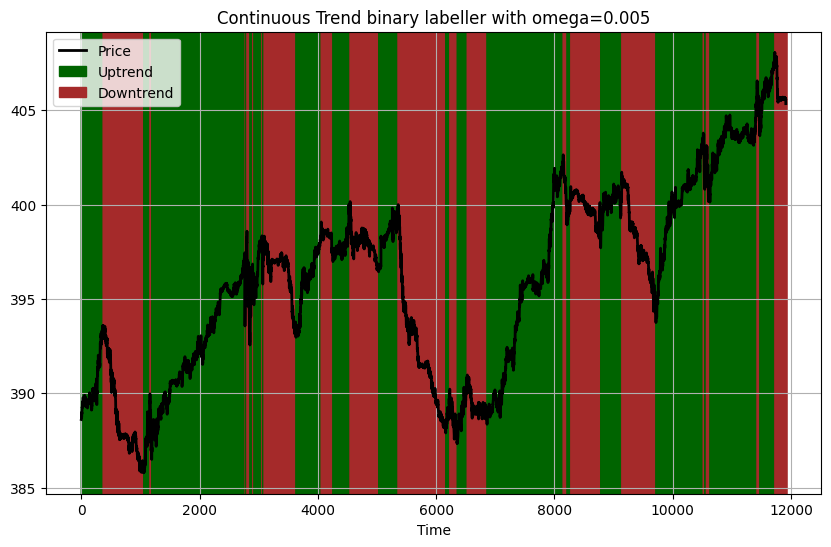

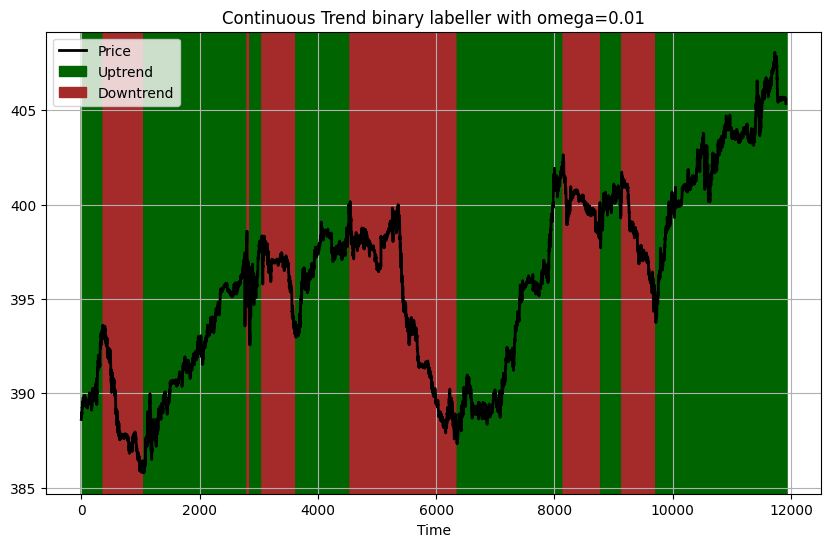

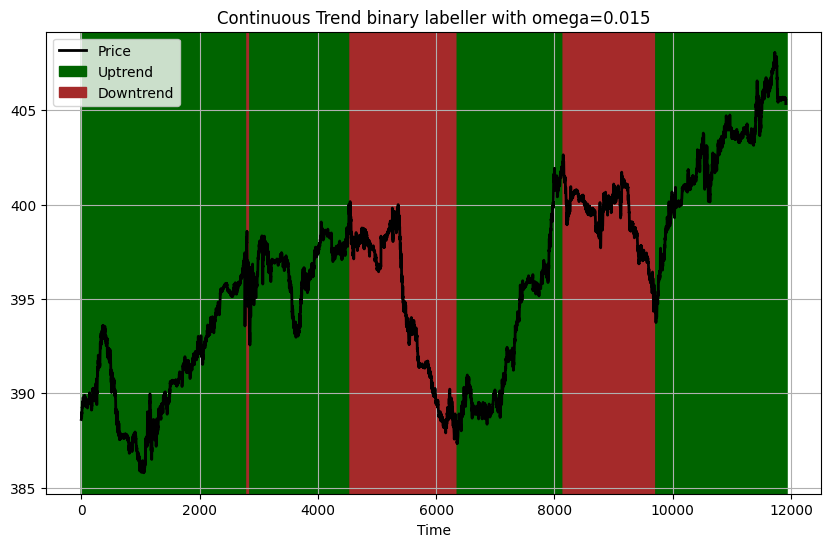

In [37]:
for omega_value in [0.001,0.005, 0.01, 0.015]:
    labels = BinaryCTL(omega=omega_value).get_labels(time_series)
    plot_trend_labels(time_series, labels, title=f"Continuous Trend binary labeller with omega={omega_value}")


# Using the Ternary CTL labeller

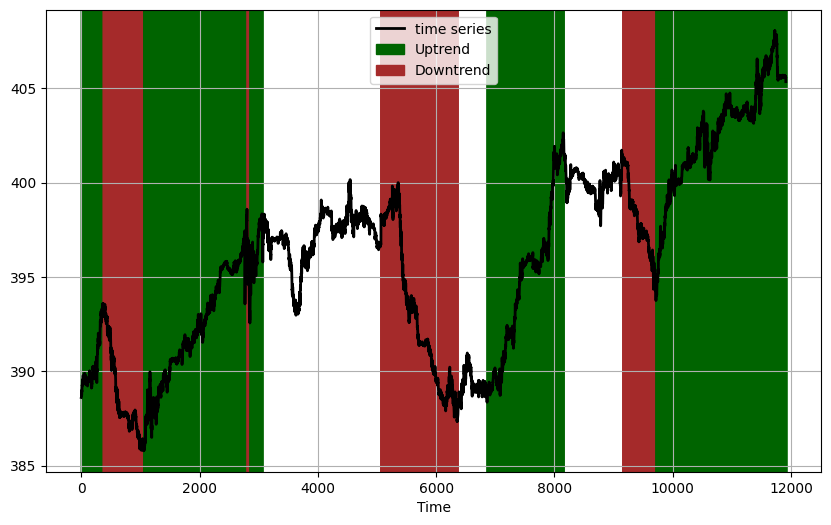

In [29]:
labels = TernaryCTL(marginal_change_thres=0.01, window_size=500).get_labels(time_series)
plot_trend_labels(time_series, labels)

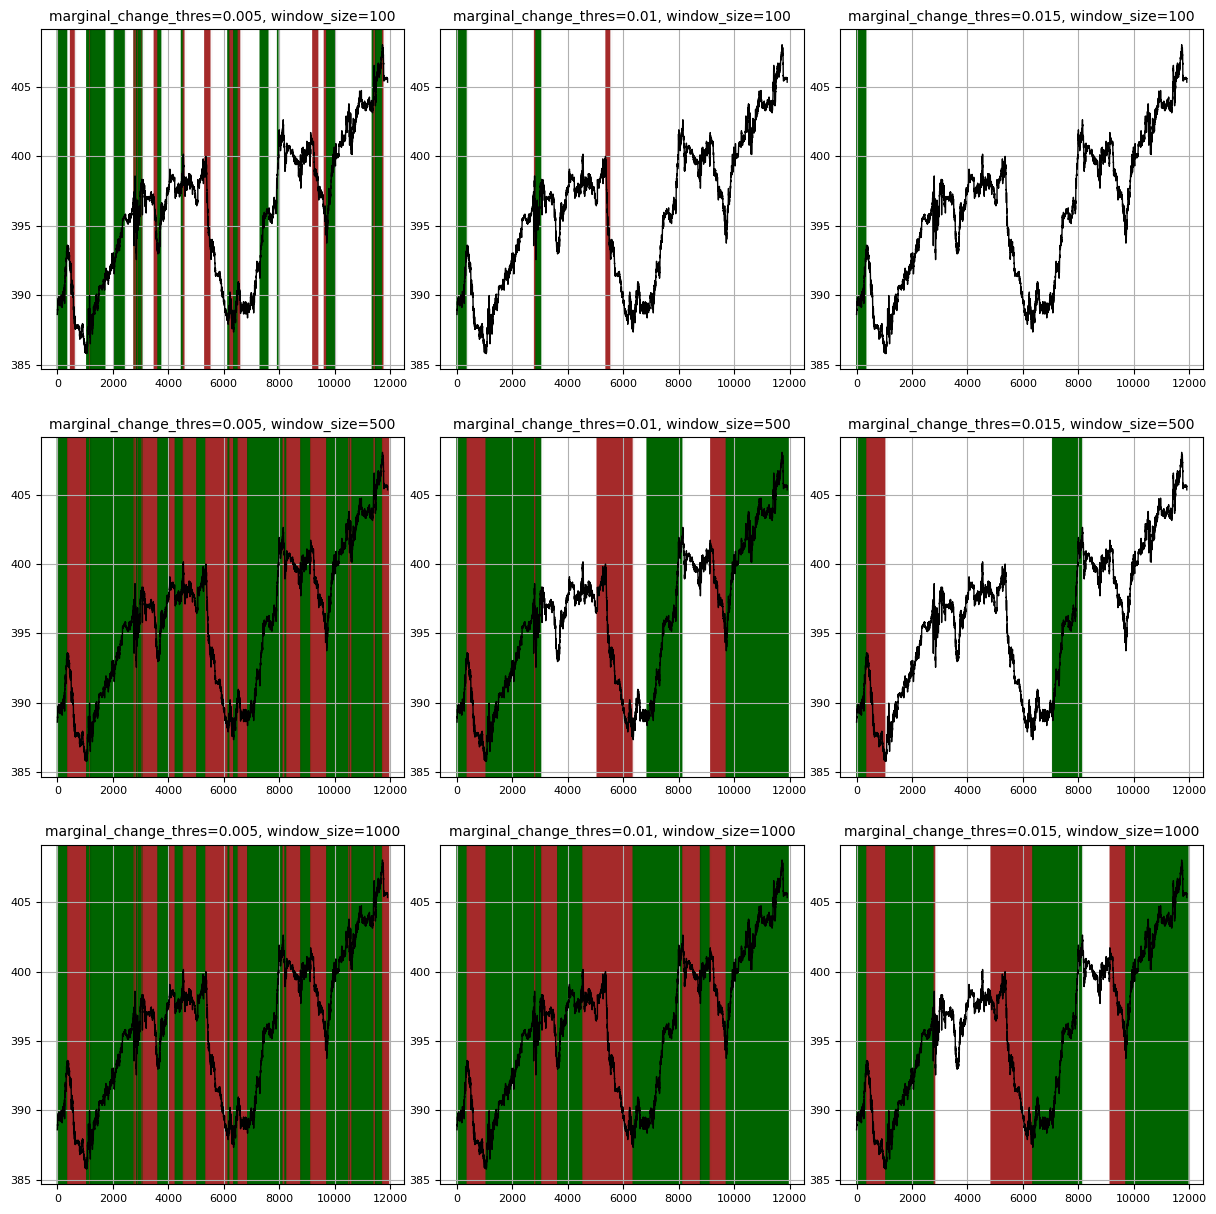

In [18]:
# Example usage for TernaryCTL
from trend_labelling.ternary_CTL import TernaryCTL


param_grid = {
    'marginal_change_thres': [0.005, 0.01, 0.015],
    'window_size': [100, 500, 1000]
}
plot_parameter_grid(TernaryCTL, time_series, param_grid)


# 3. Using the Binary Oracle labeller

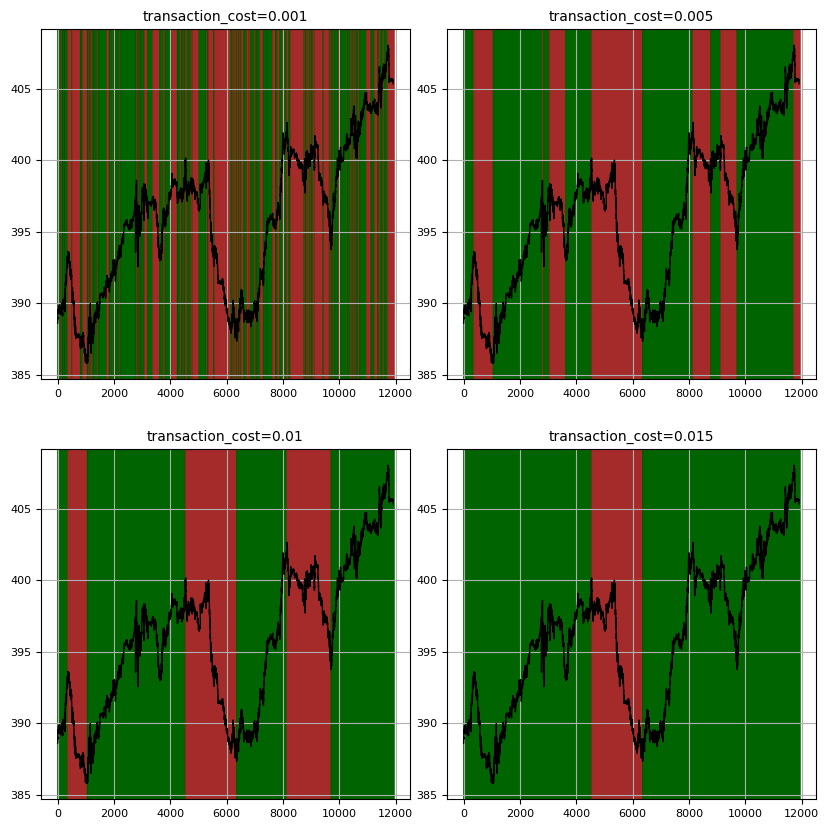

In [23]:
# Example usage for the binary oracle labeller
from trend_labelling.oracle_labeller import OracleBinaryTrendLabeller

plot_single_labeller_grid(OracleBinaryTrendLabeller, time_series, [{"transaction_cost": val} for val in [0.001,0.01, 0.005, 0.015]], (2,2), (10,10))

# Using the Ternary Oracle labeller

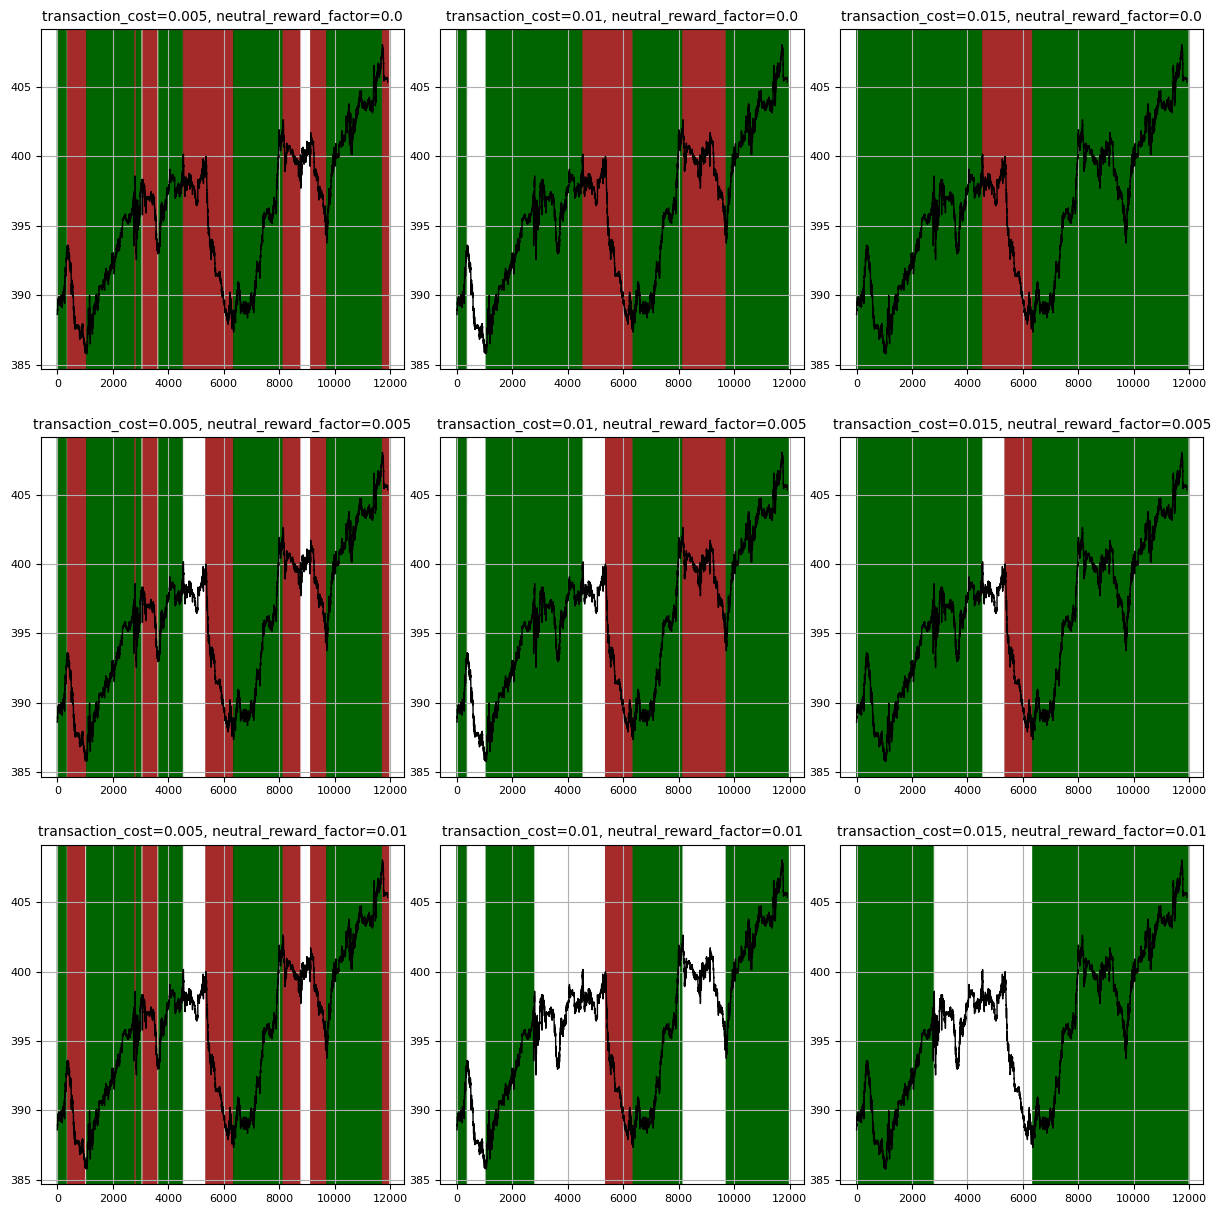

In [28]:
# Example usage for Oracle Ternary labeller
from trend_labelling.oracle_labeller import OracleTernaryTrendLabeller


param_grid = {
    'transaction_cost': [0.005, 0.01, 0.015],
    'neutral_reward_factor': [0.0, 0.005, 0.01]
}
plot_parameter_grid(OracleTernaryTrendLabeller, time_series, param_grid)
